# Author: Md. Saidur Rahman Sujon
# GRIP @ The Spark Foundation
# Task 7: Stock Market Prediction using Numerical and Textual Analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/india-news-headline/india-news-headlines.csv
/kaggle/input/apple-stock-price-2018-2022/AAPL.csv


# **Importing Libraries**

In [2]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
     

2024-03-19 17:44:15.073145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 17:44:15.073294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 17:44:15.277651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Phase 1 : Importing Datasets and Performing EDA

In [3]:
stock_price = pd.read_csv('/kaggle/input/apple-stock-price-2018-2022/AAPL.csv')
news_headlines = pd.read_csv('/kaggle/input/india-news-headline/india-news-headlines.csv')

In [4]:
print(stock_price.shape)
print(stock_price.info())
stock_price.head()

(1021, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1021 non-null   object 
 1   Open       1021 non-null   float64
 2   High       1021 non-null   float64
 3   Low        1021 non-null   float64
 4   Close      1021 non-null   float64
 5   Adj Close  1021 non-null   float64
 6   Volume     1021 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 56.0+ KB
None


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.670967,102223600
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,40.663883,118071600
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,40.852779,89738400
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.317898,94640000
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.164433,82271200


In [5]:
stock_price.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1016,2022-01-13,175.779999,176.619995,171.789993,172.190002,170.027878,84505800
1017,2022-01-14,171.339996,173.779999,171.089996,173.070007,170.896851,80440800
1018,2022-01-18,171.509995,172.539993,169.410004,169.800003,167.667862,90956700
1019,2022-01-19,170.000000,171.080002,165.940002,166.229996,164.142700,94815000
1020,2022-01-20,166.979996,169.679993,164.179993,164.509995,162.444290,91420500


In [6]:
stock_price.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [7]:
print(news_headlines.shape)
print(news_headlines.info())
news_headlines.head()

(3650970, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB
None


,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [8]:
news_headlines.tail()

,publish_date,headline_category,headline_text
3650965,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...
3650969,20220331,city.salem,Tamil Nadu sees marginal rise of Covid cases w...


In [9]:
news_headlines.isna().any()

publish_date         False
headline_category    False
headline_text        False
dtype: bool

# Phase 2 : Feature Engineering

In [10]:
stock_price = stock_price.drop_duplicates()
print(stock_price.info())
stock_price['Date'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1021 non-null   object 
 1   Open       1021 non-null   float64
 2   High       1021 non-null   float64
 3   Low        1021 non-null   float64
 4   Close      1021 non-null   float64
 5   Adj Close  1021 non-null   float64
 6   Volume     1021 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 56.0+ KB
None


0    2018-01-02
1    2018-01-03
2    2018-01-04
3    2018-01-05
4    2018-01-08
Name: Date, dtype: object

In [11]:
# Converting Date Attribute data type from object to datetime
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()
stock_price['Date'].head()

0   2018-01-02
1   2018-01-03
2   2018-01-04
3   2018-01-05
4   2018-01-08
Name: Date, dtype: datetime64[ns]

In [12]:
# Filtering the necessary columns only
stock_price = stock_price.filter(['Date','Open','High','Low','Close','Volume'])
stock_price.head()

,Date,Open,High,Low,Close,Volume
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200


In [13]:
# Setting Date as column index
stock_price.set_index('Date', inplace=True)


In [14]:
stock_price.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200


In [15]:
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200
2018-01-09,43.637501,43.764999,43.352501,43.582500,86336000
2018-01-10,43.290001,43.575001,43.250000,43.572498,95839600
2018-01-11,43.647499,43.872501,43.622501,43.820000,74670800
2018-01-12,44.044998,44.340000,43.912498,44.272499,101672400


In [16]:
print(stock_price.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1021 entries, 2018-01-02 to 2022-01-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1021 non-null   float64
 1   High    1021 non-null   float64
 2   Low     1021 non-null   float64
 3   Close   1021 non-null   float64
 4   Volume  1021 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 47.9 KB
None


# Phase 2.2 : News Headlines Data

In [17]:
print(news_headlines.info())
news_headlines.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB
None


,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [18]:
news_headlines = news_headlines.drop_duplicates()
news_headlines['publish_date'] = news_headlines['publish_date'].astype(str)

In [19]:
news_headlines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3626110 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       object
 1   headline_category  object
 2   headline_text      object
dtypes: object(3)
memory usage: 110.7+ MB


In [20]:
news_headlines['publish_date'] = news_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])

In [21]:
news_headlines['publish_date'].head()

0    2001-01-02
1    2001-01-02
2    2001-01-02
3    2001-01-02
4    2001-01-02
Name: publish_date, dtype: object

In [22]:
news_headlines['publish_date'] = pd.to_datetime(news_headlines['publish_date']).dt.normalize()

In [23]:
news_headlines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3626110 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 110.7+ MB


In [24]:
# Filter necessary columns
news_headlines = news_headlines.filter(['publish_date','headline_text'])
news_headlines.head(7)

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic
5,2001-01-02,Dilute the power of transfers; says Riberio
6,2001-01-02,Focus shifts to teaching of Hindi


In [25]:
# grouping news headlines according to 'Date'
news_headlines = news_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting 'publish_date' as index column
news_headlines.set_index('publish_date', inplace=True)

# sorting based on 'publish_date'
news_headlines = news_headlines.sort_index(ascending=True, axis=0)

In [26]:
news_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


# Phase 2.3 :Combining Stock Price and News Headlines

In [27]:
stock_data = pd.concat([stock_price,news_headlines],axis=1)
stock_data.head(10)

,Open,High,Low,Close,Volume,headline_text
2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,Big Bash League: Where; when and how to watch ...
2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,"High-quality heroin worth Rs 15 crore seized,B..."
2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,Bones with blood stains found dumped near dust...
2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,In maths; Vijayawada students a notch above th...
2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200.0,"Two endeavours; one aim: Easing lives,Awarenes..."
2018-01-09,43.637501,43.764999,43.352501,43.582500,86336000.0,Ranveer Singh and Deepika Padukone to Tiger Sh...
2018-01-10,43.290001,43.575001,43.250000,43.572498,95839600.0,Coaching classes fume over proposed Act to reg...
2018-01-11,43.647499,43.872501,43.622501,43.820000,74670800.0,Rajini mandrams in Madurai raring to get to wo...
2018-01-12,44.044998,44.340000,43.912498,44.272499,101672400.0,"Learn the right way to apply a highlighter,Ant..."
2018-01-16,44.474998,44.847500,44.035000,44.047501,118263600.0,"Gangasagar event logs record dips this year,Th..."


In [28]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7717 entries, 2018-01-02 to 2022-03-31
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           1021 non-null   float64
 1   High           1021 non-null   float64
 2   Low            1021 non-null   float64
 3   Close          1021 non-null   float64
 4   Volume         1021 non-null   float64
 5   headline_text  7717 non-null   object 
dtypes: float64(5), object(1)
memory usage: 422.0+ KB


In [29]:
stock_data.dropna(axis=0, inplace=True)

In [30]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1021 entries, 2018-01-02 to 2022-01-20
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           1021 non-null   float64
 1   High           1021 non-null   float64
 2   Low            1021 non-null   float64
 3   Close          1021 non-null   float64
 4   Volume         1021 non-null   float64
 5   headline_text  1021 non-null   object 
dtypes: float64(5), object(1)
memory usage: 55.8+ KB


## Phase 2.4: Combine additional sentiments

In [31]:
stock_data['compound'] = ""
stock_data['positive'] = ""
stock_data['negative'] = ""
stock_data['neutral'] = ""

In [32]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1021 entries, 2018-01-02 to 2022-01-20
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           1021 non-null   float64
 1   High           1021 non-null   float64
 2   Low            1021 non-null   float64
 3   Close          1021 non-null   float64
 4   Volume         1021 non-null   float64
 5   headline_text  1021 non-null   object 
 6   compound       1021 non-null   object 
 7   positive       1021 non-null   object 
 8   negative       1021 non-null   object 
 9   neutral        1021 non-null   object 
dtypes: float64(5), object(5)
memory usage: 87.7+ KB


In [33]:
import nltk.sentiment.vader as sid
from unicodedata import normalize

# Assuming you have a DataFrame named stock_data with a 'headline_text' column

# Create a SentimentIntensityAnalyzer object
sid = sid.SentimentIntensityAnalyzer()

# Add a 'compound' column to store sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(normalize('NFKD', x))['compound'])

# Add columns for negative, neutral, and positive sentiment scores
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(normalize('NFKD', x))['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(normalize('NFKD', x))['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(normalize('NFKD', x))['pos'])

# Display the first few rows of the DataFrame with sentiment scores
print(stock_data.head())

                 Open       High        Low      Close       Volume  \
2018-01-02  42.540001  43.075001  42.314999  43.064999  102223600.0   
2018-01-03  43.132500  43.637501  42.990002  43.057499  118071600.0   
2018-01-04  43.134998  43.367500  43.020000  43.257500   89738400.0   
2018-01-05  43.360001  43.842499  43.262501  43.750000   94640000.0   
2018-01-08  43.587502  43.902500  43.482498  43.587502   82271200.0   

                                                headline_text  compound  \
2018-01-02  Big Bash League: Where; when and how to watch ...   -0.9993   
2018-01-03  High-quality heroin worth Rs 15 crore seized,B...   -0.9995   
2018-01-04  Bones with blood stains found dumped near dust...   -0.9999   
2018-01-05  In maths; Vijayawada students a notch above th...   -0.9998   
2018-01-08  Two endeavours; one aim: Easing lives,Awarenes...   -0.9998   

            positive  negative  neutral  
2018-01-02     0.085     0.109    0.806  
2018-01-03     0.058     0.098    0.84

In [34]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1021 entries, 2018-01-02 to 2022-01-20
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           1021 non-null   float64
 1   High           1021 non-null   float64
 2   Low            1021 non-null   float64
 3   Close          1021 non-null   float64
 4   Volume         1021 non-null   float64
 5   headline_text  1021 non-null   object 
 6   compound       1021 non-null   float64
 7   positive       1021 non-null   float64
 8   negative       1021 non-null   float64
 9   neutral        1021 non-null   float64
dtypes: float64(9), object(1)
memory usage: 87.7+ KB


In [35]:
stock_data.head()

,Open,High,Low,Close,Volume,headline_text,compound,positive,negative,neutral
2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,Big Bash League: Where; when and how to watch ...,-0.9993,0.085,0.109,0.806
2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,"High-quality heroin worth Rs 15 crore seized,B...",-0.9995,0.058,0.098,0.844
2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,Bones with blood stains found dumped near dust...,-0.9999,0.084,0.151,0.766
2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,In maths; Vijayawada students a notch above th...,-0.9998,0.090,0.134,0.776
2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200.0,"Two endeavours; one aim: Easing lives,Awarenes...",-0.9998,0.097,0.138,0.765


In [36]:
stock_data.to_csv('/kaggle/working/outstock_final.csv')

In [37]:
stock_data = pd.read_csv('/kaggle/working/outstock_final.csv')
stock_data.head()

,Unnamed: 0,Open,High,Low,Close,Volume,headline_text,compound,positive,negative,neutral
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,Big Bash League: Where; when and how to watch ...,-0.9993,0.085,0.109,0.806
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,"High-quality heroin worth Rs 15 crore seized,B...",-0.9995,0.058,0.098,0.844
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,Bones with blood stains found dumped near dust...,-0.9999,0.084,0.151,0.766
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,In maths; Vijayawada students a notch above th...,-0.9998,0.090,0.134,0.776
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200.0,"Two endeavours; one aim: Easing lives,Awarenes...",-0.9998,0.097,0.138,0.765


In [38]:
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
stock_data.head()

,Date,Open,High,Low,Close,Volume,headline_text,compound,positive,negative,neutral
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,Big Bash League: Where; when and how to watch ...,-0.9993,0.085,0.109,0.806
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,"High-quality heroin worth Rs 15 crore seized,B...",-0.9995,0.058,0.098,0.844
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,Bones with blood stains found dumped near dust...,-0.9999,0.084,0.151,0.766
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,In maths; Vijayawada students a notch above th...,-0.9998,0.090,0.134,0.776
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200.0,"Two endeavours; one aim: Easing lives,Awarenes...",-0.9998,0.097,0.138,0.765


In [39]:
stock_data.set_index('Date', inplace=True)
stock_data.head()

,Open,High,Low,Close,Volume,headline_text,compound,positive,negative,neutral
Date,,,,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,Big Bash League: Where; when and how to watch ...,-0.9993,0.085,0.109,0.806
2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,"High-quality heroin worth Rs 15 crore seized,B...",-0.9995,0.058,0.098,0.844
2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,Bones with blood stains found dumped near dust...,-0.9999,0.084,0.151,0.766
2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,In maths; Vijayawada students a notch above th...,-0.9998,0.090,0.134,0.776
2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200.0,"Two endeavours; one aim: Easing lives,Awarenes...",-0.9998,0.097,0.138,0.765


In [40]:
stock_data.shape

(1021, 10)

In [41]:
stock_data.isna().any()

Open             False
High             False
Low              False
Close            False
Volume           False
headline_text    False
compound         False
positive         False
negative         False
neutral          False
dtype: bool

In [42]:
stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume', 'compound','positive', 'negative','neutral']]

In [43]:
stock_data.describe(include='all')

,Open,High,Low,Close,Volume,compound,positive,negative,neutral
count,1021.000000,1021.000000,1021.000000,1021.000000,1.021000e+03,1021.000000,1021.000000,1021.000000,1021.000000
mean,85.035451,86.009153,84.112287,85.097706,1.236718e+08,-0.977906,0.078606,0.130008,0.791387
std,41.394259,41.860999,40.914282,41.397348,5.793803e+07,0.204510,0.012477,0.019372,0.025162
min,35.994999,36.430000,35.500000,35.547501,4.100000e+07,-1.000000,0.043000,0.068000,0.730000
25%,48.264999,48.740002,47.904999,48.334999,8.450580e+07,-0.999900,0.070000,0.117000,0.774000
50%,67.150002,68.139999,66.457497,67.677498,1.089237e+08,-0.999800,0.078000,0.131000,0.789000
75%,124.680000,126.150002,123.070000,124.824997,1.461188e+08,-0.999600,0.087000,0.143000,0.807000
max,182.630005,182.940002,179.119995,182.009995,4.265100e+08,0.999700,0.126000,0.199000,0.878000


In [44]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1021 entries, 2018-01-02 to 2022-01-20
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      1021 non-null   float64
 1   High      1021 non-null   float64
 2   Low       1021 non-null   float64
 3   Close     1021 non-null   float64
 4   Volume    1021 non-null   float64
 5   compound  1021 non-null   float64
 6   positive  1021 non-null   float64
 7   negative  1021 non-null   float64
 8   neutral   1021 non-null   float64
dtypes: float64(9)
memory usage: 79.8+ KB


Text(0, 0.5, 'Closed Price in ($)')

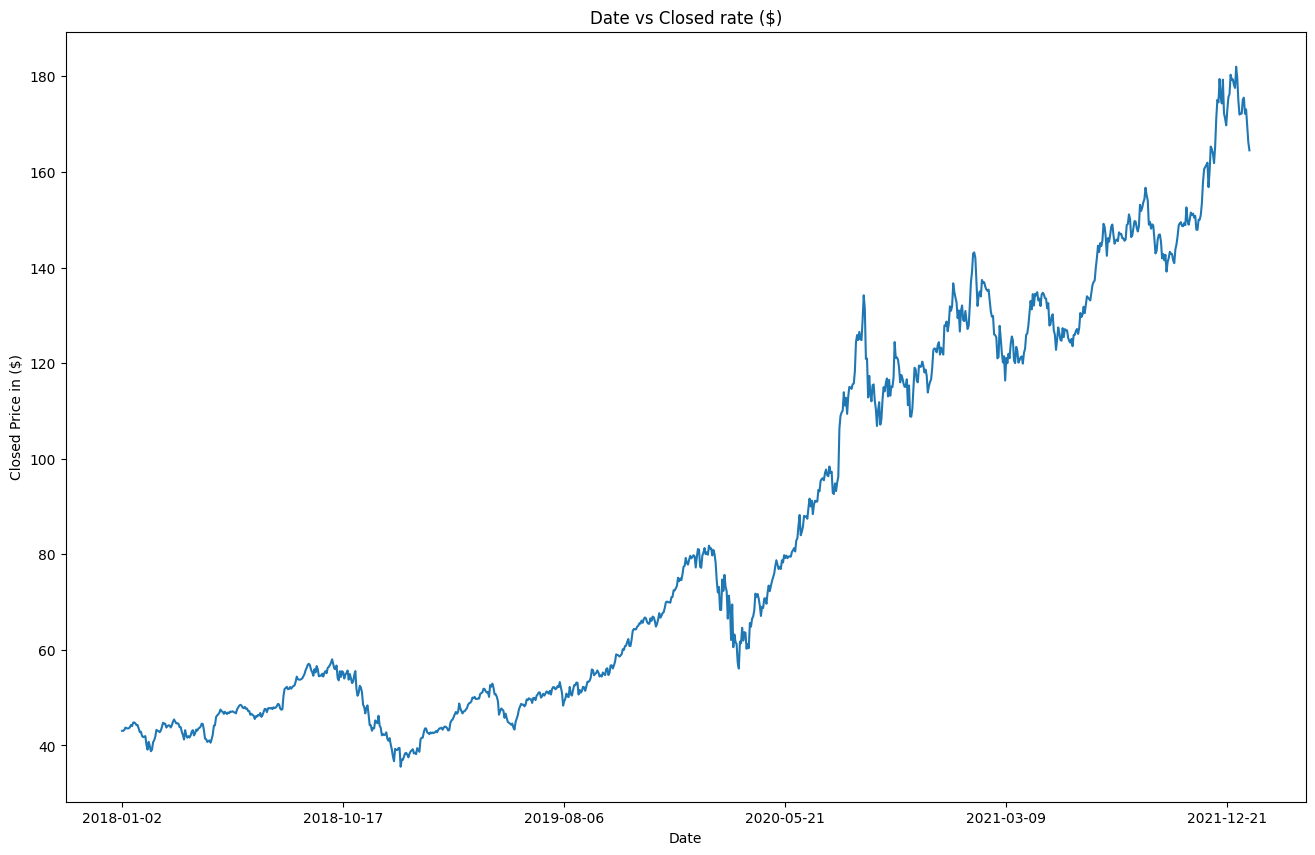

In [45]:
plt.figure(figsize=(16,10))
stock_data['Close'].plot()
plt.title('Date vs Closed rate ($)')
plt.xlabel('Date')
plt.ylabel('Closed Price in ($)')

In [46]:
# 7 Day rolling mean calculation
stock_data.rolling(7).mean().head(10)

,Open,High,Low,Close,Volume,compound,positive,negative,neutral
Date,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,43.240358,43.595000,43.096072,43.410357,9.558863e+07,-0.999714,0.083143,0.128571,0.788571
2018-01-11,43.398572,43.708929,43.282858,43.518214,9.165251e+07,-0.999800,0.083857,0.133714,0.782714
2018-01-12,43.528929,43.809286,43.414643,43.691786,8.930977e+07,-0.999857,0.087714,0.140000,0.772571


<Axes: xlabel='Date'>

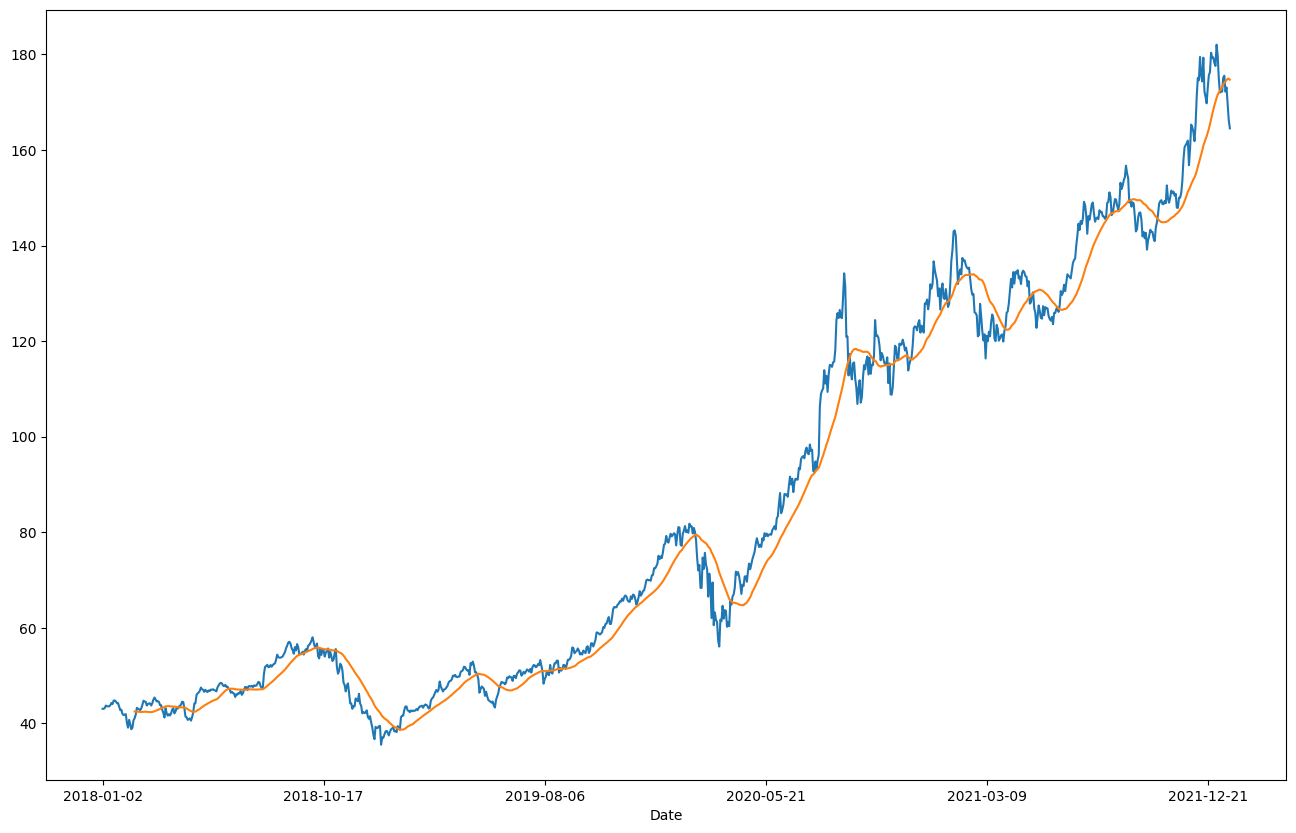

In [47]:
plt.figure(figsize=(16,10))
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

## Phase 3: Data Preprocessing

In [48]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 816
Number of records in Test Data: 205


In [49]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2018-01-03     43.132500
2018-01-04     43.134998
2018-01-05     43.360001
2018-01-08     43.587502
2018-01-09     43.637501
                 ...    
2022-01-13    175.779999
2022-01-14    171.339996
2022-01-18    171.509995
2022-01-19    170.000000
2022-01-20    166.979996
Name: Open, Length: 1020, dtype: float64

In [50]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2018-01-03,43.132500,43.134998,43.637501,43.367500,0.844,-0.9995,0.058,0.098
2018-01-04,43.134998,43.360001,43.367500,43.842499,0.766,-0.9999,0.084,0.151
2018-01-05,43.360001,43.587502,43.842499,43.902500,0.776,-0.9998,0.090,0.134
2018-01-08,43.587502,43.637501,43.902500,43.764999,0.765,-0.9998,0.097,0.138
2018-01-09,43.637501,43.290001,43.764999,43.575001,0.767,-0.9998,0.096,0.137
2018-01-10,43.290001,43.647499,43.575001,43.872501,0.796,-0.9999,0.072,0.133
2018-01-11,43.647499,44.044998,43.872501,44.340000,0.765,-0.9999,0.090,0.145
2018-01-12,44.044998,44.474998,44.340000,44.847500,0.773,-0.9999,0.085,0.142
2018-01-16,44.474998,44.037498,44.847500,44.812500,0.778,-0.9999,0.075,0.147


## Phase 5: Setting Target Variable

In [85]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2018-01-03     43.134998
2018-01-04     43.360001
2018-01-05     43.587502
2018-01-08     43.637501
2018-01-09     43.290001
                 ...    
2022-01-12    175.779999
2022-01-13    171.339996
2022-01-14    171.509995
2022-01-18    170.000000
2022-01-19    166.979996
Name: close_price_shifted, Length: 1019, dtype: float64

In [86]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2018-01-03,43.132500,43.637501,43.367500,0.844,-0.9995,0.058,0.098
2018-01-04,43.134998,43.367500,43.842499,0.766,-0.9999,0.084,0.151
2018-01-05,43.360001,43.842499,43.902500,0.776,-0.9998,0.090,0.134
2018-01-08,43.587502,43.902500,43.764999,0.765,-0.9998,0.097,0.138
2018-01-09,43.637501,43.764999,43.575001,0.767,-0.9998,0.096,0.137
...,...,...,...,...,...,...,...
2022-01-12,176.119995,177.179993,176.619995,0.768,-0.9999,0.087,0.145
2022-01-13,175.779999,176.619995,173.779999,0.816,-0.9990,0.080,0.105
2022-01-14,171.339996,173.779999,172.539993,0.826,-0.9998,0.059,0.115


### Scaling target Variable and Feature Dataset

Given that LSTM is being used to forecast stock prices, which are time series data, it is critical to comprehend how sensitive LSTM may be to data size. As of right now, the data may be examined on several scales. Rescaling the data is crucial in order to ensure that the dataset's range is consistent for the majority of its records. In this case, the feature range is (-1,1).

In [87]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.90264943, -0.9016108 , -0.90529657, ..., -0.99949992,
         -0.63855422, -0.54198473],
        [-0.90261536, -0.90529657, -0.89881238, ..., -0.99989998,
         -0.01204819,  0.26717557],
        [-0.89954647, -0.89881238, -0.89799331, ..., -0.99979997,
          0.13253012,  0.00763359],
        ...,
        [ 0.84601209,  0.8749573 ,  0.85803005, ..., -0.99979997,
         -0.61445783, -0.28244275],
        [ 0.84833076,  0.85803005,  0.83809979, ..., -0.99929989,
         -0.15662651, -0.32824427],
        [ 0.82773547,  0.83809979,  0.81898834, ..., -0.99979997,
         -0.20481928, -0.00763359]]),
 array([[-0.90261536],
        [-0.89954647],
        [-0.89644351],
        ...,
        [ 0.84833076],
        [ 0.82773547],
        [ 0.78654471]]))

Train_test_split, a function of the sklearn package, is often used for any other dataset. However, time series data, like as stock prices, which are dependent on dates, require a separate division of the dataset into train and test datasets, as seen below. An observation on a given date in a timeseries data set is always reliant on the records from earlier dates.

In [88]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (816, 7) and y: (816, 1)
Number of rows and columns in the Test set X: (202, 7) and y: (202, 1)


In [89]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (816, 7, 1)
Shape of Test set X: (202, 7, 1)


## Phase 9: Data Modelling

In [90]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))

model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 7, 100)            40800     
                                                                 
 dropout_18 (Dropout)        (None, 7, 100)            0         
                                                                 
 lstm_19 (LSTM)              (None, 7, 100)            80400     
                                                                 
 dropout_19 (Dropout)        (None, 7, 100)            0         
                                                                 
 lstm_20 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_20 (Dropout)        (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [91]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.35, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
67/67 [==============================] - 8s 37ms/step - loss: 0.0621 - val_loss: 0.1728
Epoch 2/50
67/67 [==============================] - 1s 17ms/step - loss: 0.0077 - val_loss: 0.1033
Epoch 3/50
67/67 [==============================] - 1s 17ms/step - loss: 0.0060 - val_loss: 0.0496
Epoch 4/50
67/67 [==============================] - 1s 18ms/step - loss: 0.0055 - val_loss: 0.0271
Epoch 5/50
67/67 [==============================] - 1s 19ms/step - loss: 0.0045 - val_loss: 0.0143
Epoch 6/50
67/67 [==============================] - 1s 21ms/step - loss: 0.0050 - val_loss: 0.0115
Epoch 7/50
67/67 [==============================] - 1s 17ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 8/50
67/67 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 9/50
67/67 [==============================] - 1s 17ms/step - loss: 0.0035 - val_loss: 0.0289
Epoch 10/50
67/67 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0517
Epoch 11/

In [92]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('/kaggle/working/model.h5')
print('Model is saved to the kaggle virtual output')

Model is saved to the kaggle virtual output


## Phase 10: Performing Prediction

In [93]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

7/7 [==============================] - 1s 7ms/step
Predictions:


array([[102.88292 ],
       [105.10326 ],
       [105.417534],
       [105.98589 ],
       [105.70705 ]], dtype=float32)

## Phase 11: Model Evaluation

In [94]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

202/202 [==============================] - 1s 6ms/step - loss: 0.2778
Train Loss = 0.0179
Test Loss = 0.2778


In [95]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 109.4371


In [96]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 109.4371


## Phase 12: Plotting the prediction against the hidden data

In [97]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

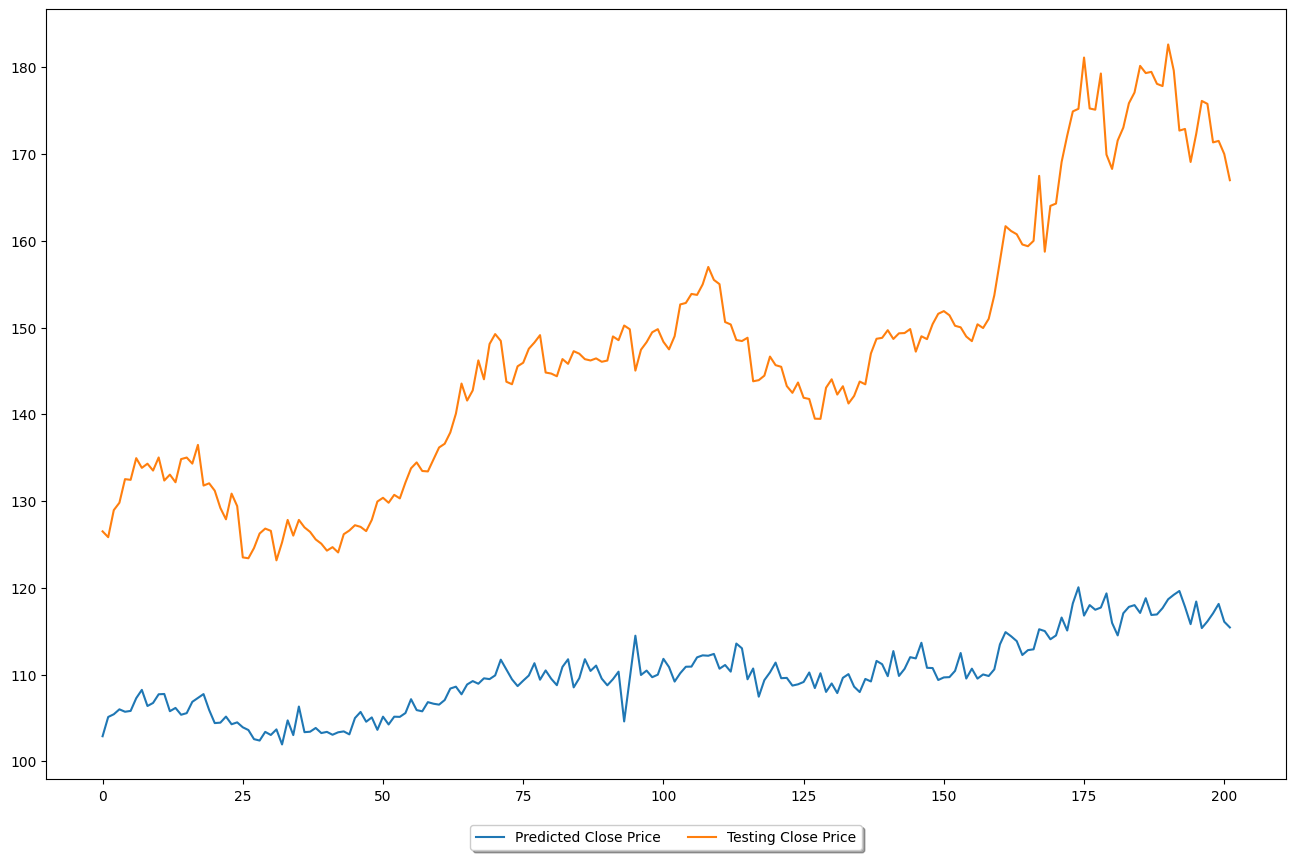

In [98]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()